In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.0 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
import transformers
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
#List of all NDA's in the dataset. 
kes=['nda-11', 'nda-16', 'nda-15', 'nda-10', 'nda-2', 'nda-1', 'nda-19', 'nda-12', 'nda-20', 'nda-3', 'nda-18', 'nda-7', 'nda-17', 'nda-8', 'nda-13', 'nda-5', 'nda-4']

#method to load json file
def get_json(path):  
  #################
  # Opening JSON file
  f = open(path)  
  # returns JSON object as 
  # a dictionary
  data = json.load(f)
  f.close()
  return data

#clean text
def preprocess(sentence):
  sentence=str(sentence)
  sentence = re.sub(r'[^A-Za-z0-9]+', ' ', sentence) 
  sentence = re.sub(r'https?:/\/\S+', ' ', sentence) 
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_url)  
  return " ".join(tokens)

In [4]:
# Do Not delete
def get_data(data, idx,ke, max_neutral=3):
  dataM=[]
  #Document level
  docid = data['documents'][idx]['id']
  
  string = data['documents'][idx]['text']
  file_name = data['documents'][idx]['file_name']
  spans = data['documents'][idx]['spans']
  spanall=[]
  for span in spans:           
      spanval = string[span[0]: span[1]]
      spanall.append(spanval)
  
  ndas = data['documents'][idx]['annotation_sets'][0]['annotations'] 
  # Keys level
    
  hypothesis = data['labels'][ke]['hypothesis']  

  # Key level   

  choice =ndas[ke] ['choice']
  spansC = ndas[ke] ['spans']    
  for si in range(len(spanall)):
    span_nbr =si
    if si in spansC:
      val=choice
    else:
      val="Neutral"
    premise = spanall[si]
    itm = [docid, file_name , ke, hypothesis, span_nbr, premise,val ]
    dataM.append(itm)
  df = pd.DataFrame(dataM ,columns = ['docid', 'file_name', 'hypotheis_key', 'hypotheis', 'span_nbr', 'premise', 'choice'   ])
  #"[CLS] " and " [SEP] "" [SEP]" 
  df['premise'] = df['premise'].apply(preprocess)
  df['hypotheis']= df['hypotheis'].apply(preprocess) 
  df['label'] = df['choice'].map(lambda s: 0 if s=='Entailment' else (1 if s== 'Contradiction' else 2 ))
  df['entl'] =  df['choice'].map(lambda s : 1 if s== 'Entailment' else 0)
  df['cont'] =  df['choice'].map(lambda s : 1 if s== 'Contradiction' else 0)
  df['neut'] =  df['choice'].map(lambda s : 1 if s== 'Neutral' else 0)

  df1=df[df.choice !='Neutral']
  df2=df[df.choice =='Neutral']
  n = min(max_neutral, len(df2)-1)
  df2= df2.sample(n = n)
  df = pd.concat([df1, df2], sort=False)
  df = df[df.span_nbr !=-1 ][df.premise != ''] [df.hypotheis != '']
  return df

In [5]:

def create_documents_df(data, kes):
  df = pd.DataFrame([], columns=['docid','file_name','hypotheis_key','hypotheis','span_nbr','premise','choice','label','entl',	'cont','neut','bert_sent'])
  for idx in range(len(data['documents'])):
    for ke in kes:
      ad = get_data(data, idx, ke)
      df = df.append(ad)
  
  return df[["hypotheis","premise","label"]]

In [6]:
data = get_json('/content/train.json')
dataT = get_json('/content/test.json')

df_train = create_documents_df(data, kes)
df_test = create_documents_df(dataT, kes)

<ipython-input-4-67e0a56ceade>:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.span_nbr !=-1 ][df.premise != ''] [df.hypotheis != '']


[Text(0.5, 0, 'Labels')]

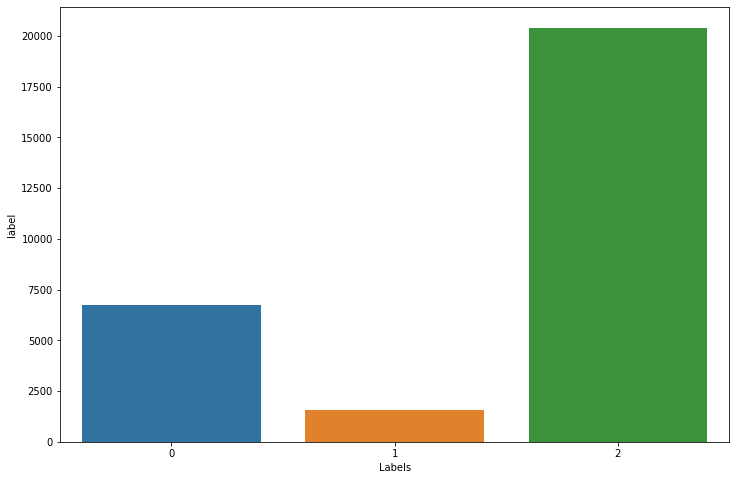

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
 
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=df_train.label.unique(), y=df_train.label.value_counts())

ax.set(xlabel='Labels')

In [ ]:
df_train.head()

In [ ]:
df_train[df_train["premise"] != ""]

In [11]:
df_train[df_train["hypotheis"] != ""]

,hypotheis,premise,label
31,Receiving Party shall not reverse engineer any...,i obtained by the Recipient without restrictio...,2
56,Receiving Party shall not reverse engineer any...,For and on behalf of UNHCR For and on behalf o...,2
13,Receiving Party shall not reverse engineer any...,NOW THEREFORE the Parties agree as follows,2
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,0
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,0
...,...,...,...
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,0
16,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,0
89,Receiving Party shall not use any Confidential...,c irrevocably and unconditionally waives the r...,2
6,Receiving Party shall not use any Confidential...,This Agreement sets forth the Parties obligati...,2


In [17]:
df_train[df_train["label"] != 2]

,hypotheis,premise,label
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,0
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,0
38,Agreement shall not grant Receiving Party any ...,4 Nothing in this Agreement is to be construed...,0
51,Receiving Party shall not disclose the fact th...,11 The Recipient shall not advertise or otherw...,0
14,All Confidential Information shall be expressl...,1 Confidential Information whenever used in th...,0
...,...,...,...
105,Receiving Party may share some Confidential In...,i a subsidiary or other affiliate of such Part...,0
106,Receiving Party may share some Confidential In...,ii an officer director employee partner attorn...,0
9,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,0
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,0


In [18]:
df_train[df_train["label"] == 2]

,hypotheis,premise,label
31,Receiving Party shall not reverse engineer any...,i obtained by the Recipient without restrictio...,2
56,Receiving Party shall not reverse engineer any...,For and on behalf of UNHCR For and on behalf o...,2
13,Receiving Party shall not reverse engineer any...,NOW THEREFORE the Parties agree as follows,2
19,Receiving Party shall destroy or return some C...,The Recipient shall use the Confidential Infor...,2
32,Receiving Party shall destroy or return some C...,ii disclosed by the Discloser to a third party...,2
...,...,...,...
40,Receiving Party may share some Confidential In...,a make effect initiate cause or participate in,2
18,Receiving Party may share some Confidential In...,Neither the Provider nor any of the Provider s...,2
89,Receiving Party shall not use any Confidential...,c irrevocably and unconditionally waives the r...,2
6,Receiving Party shall not use any Confidential...,This Agreement sets forth the Parties obligati...,2


In [19]:
#df_train = df_train.rename(columns={'choice': 'label'})
#df_test= df_test.rename(columns={'choice': 'label'})

df_train.to_csv(r'/content/train.csv', index=False)
df_test.to_csv(r'/content/test.csv', index=False)